# Machine Learning the Atom

This is to explore how one can deploy and optimize a neural network to minimize the energy of a physical system, particularly the hydrogen atom. We are going to begin with simpler examples first.

In [242]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as colmaps
import pandas as pd
#from sklearn.model_selection import train_test_split

## Problem setup

First we will describe the problem. Let's start in 1D by solving a simple ODE.

## ODE solver

In [2]:
# Model class
class ODESolver(nn.Module):
    """
     A simple deep neural network that fits an ODE solution
    """
    def __init__(self, inp = 2, width = 10):
        # super of what? Of this class, call the constructor of the parent class of ODESolver -> nn.Module
        super(ODESolver, self).__init__() 
        self.myNet = nn.Sequential(
            nn.Linear(inp, width), #Entry point, 1D function
            nn.Tanh(),       #Activation function
            nn.Linear(width,width),
            nn.Tanh(),
            nn.Linear(width, 1) # Output layer
        )
    
    # forwards propagate in the network
    def forward(self, x):
        return self.myNet(x) 

In [3]:
# Custom loss function for unsupervised learning
def lossFunctionODE(model : nn.Module, x : torch.Tensor):

    x.requires_grad = True
    prediction = model(x)
    dudx = torch.autograd.grad(prediction, x, torch.ones_like(prediction), create_graph=True)[0]
    # True because higher order derivatives are going to be needed in backpropagation
    domain_loss = torch.linalg.vector_norm(dudx + prediction) 
    boundary_loss = (model(torch.tensor([[0.0]])) - 1) ** 2 #initial condition
    return domain_loss + boundary_loss
    

In [4]:
model = ODESolver(inp = 1, width = 5)  # Initialize the model
#optimizer = torch.optim.LBFGS(model.parameters())  # LBFGS optimizer with lr = 1, needs special 'step' treatment
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
x_train = torch.linspace(0, 2, 200).view(-1,1) # reshapes the 1D tensor to a (N,1), to enable parallel calculation and proper model feeding
errors = []
epochs = 10000
freq = 100
for epoch in range(epochs+1):
    optimizer.zero_grad()  # Reset gradients
    loss = lossFunctionODE(model, x_train)  # Compute loss
    errors.append(loss.item())
    loss.backward()  # Compute gradients
    optimizer.step()  # Update model parameters
    if epoch % freq == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}",end="\r")

Epoch 10000, Loss: 0.0056471326388418674

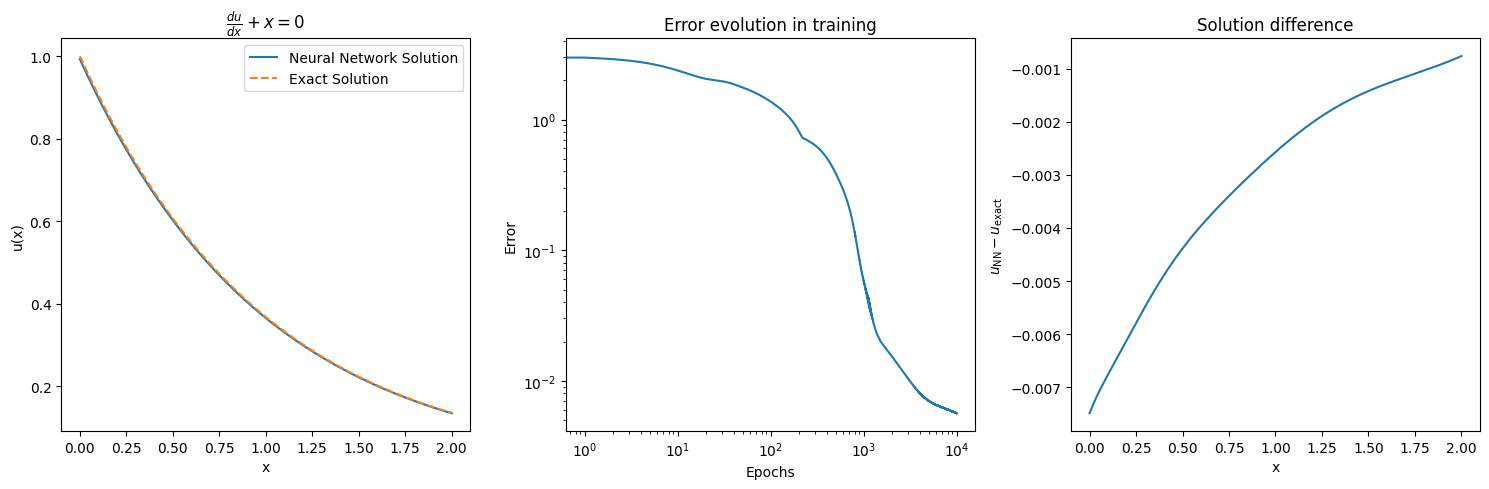

In [5]:
pred = model(x_train).detach().numpy()
np_x = x_train.detach().numpy()
exact = np.exp(-np_x)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,5))
ax1.plot(np_x, pred, label="Neural Network Solution")
ax1.plot(np_x, exact, label="Exact Solution", linestyle="dashed")
ax1.legend()
ax1.set_xlabel("x")
ax1.set_ylabel("u(x)")
ax1.set_title(r'$\frac{du}{dx} + x = 0$')

ax2.loglog(np.array(errors))
ax2.set_title("Error evolution in training")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Error")

ax3.plot(np_x, pred-exact, label="Neural Network Solution")
ax3.set_title("Solution difference")
ax3.set_xlabel("x")
ax3.set_ylabel(r'$u_\text{NN}-u_\text{exact}$')

plt.tight_layout()
plt.show()

## PDE solver

In [283]:
# Model class
class LaplaceSolver(nn.Module):
    """
     A simple deep neural network that fits a PDE solution
    """
    def __init__(self, inp = 2, width = 10):
        # super of what? Of this class, call the constructor of the parent class of ODESolver -> nn.Module
        super(LaplaceSolver, self).__init__() 
        self.myNet = nn.Sequential(
            nn.Linear(inp, width), #Entry point, 1D function
            nn.Tanh(),       #Activation function
            nn.Linear(width,width),
            nn.Tanh(),
            nn.Linear(width, 1) # Output layer
        )
        for layer in self.myNet:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)
    
    # forwards propagate in the network
    def forward(self, x):
        return self.myNet(x) 

In [304]:
# Custom loss function for unsupervised learning
def lossFunctionPDE(model : nn.Module, x : torch.Tensor, b_points : int = 10, lamb : float = 0.5):
    # make sure input is (x,y) pairs
    assert len(x[0]) == 2 

    # set spacing in the boundary
    xs = torch.linspace(0, 1, b_points)
    ys = torch.linspace(0, 1, b_points)
    
    # find the boundary points
    b_x0 = torch.cartesian_prod(torch.tensor([0.0]), ys)
    b_x1 = torch.cartesian_prod(torch.tensor([1.0]), ys)
    b_y0 = torch.cartesian_prod(xs, torch.tensor([0.0]))
    b_y1 = torch.cartesian_prod(xs, torch.tensor([1.0]))
    
    x.requires_grad = True
    prediction = model(x)
    # calculate first derivative
    dudx = torch.autograd.grad(prediction, x, torch.ones_like(prediction), create_graph=True)[0]

    # calculate the second derivative of the 1st component of the first derivative. Keep only the 1st component of the result
    dudx2 = torch.autograd.grad(dudx[:, 0], x, torch.ones_like(dudx[:, 0]), create_graph=True)[0][:,0]

    # calculate the second derivative of the 2nd component of the first derivative. Keep only the 2nd component of the result
    dudy2 = torch.autograd.grad(dudx[:, 1], x, torch.ones_like(dudx[:, 1]), create_graph=True)[0][:,1]
        
    # calculate the losses
    domain_loss = torch.linalg.vector_norm(dudx2 + dudy2) 
    boundary_loss_x0 = torch.linalg.vector_norm(model(b_x0) - torch.sin(2 * np.pi * xs))  #boundary condition x = 0
    boundary_loss_y0 = torch.linalg.vector_norm(model(b_y0))  #boundary condition y = 0
    boundary_loss_x1 = torch.linalg.vector_norm(model(b_x1) - torch.sin(2 * np.pi * xs))  #boundary condition x = 1
    boundary_loss_y1 = torch.linalg.vector_norm(model(b_y1))  #boundary condition y = 1
    
    return (lamb)*(domain_loss)/(1.0 * len(x)) + (1-lamb)*(boundary_loss_x0 + boundary_loss_y0 + boundary_loss_x1 + boundary_loss_y1)/(4.0 * b_points)
    

In [305]:
model = LaplaceSolver(inp = 2, width = 20)  # Initialize the model
#optimizer = torch.optim.LBFGS(model.parameters())  # LBFGS optimizer with lr = 1, needs special 'step' treatment
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Training loop
mesh_length = 15
x_train = torch.linspace(0, 1, mesh_length)
y_train = torch.linspace(0, 1, mesh_length)
xy_train = torch.cartesian_prod(x_train, y_train)

errors = []
epochs = 3000
freq = 100

for epoch in range(epochs+1):
    optimizer.zero_grad()  # Reset gradients
    loss = lossFunctionPDE(model, xy_train, 30, lamb= 1e-3)  # Compute loss, number is the boundary resolution
    errors.append(loss.item())
    loss.backward()  # Compute gradients
    optimizer.step()  # Update model parameters
    if epoch % freq == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}",end="\r")

Epoch 3000, Loss: 0.34776416420936584

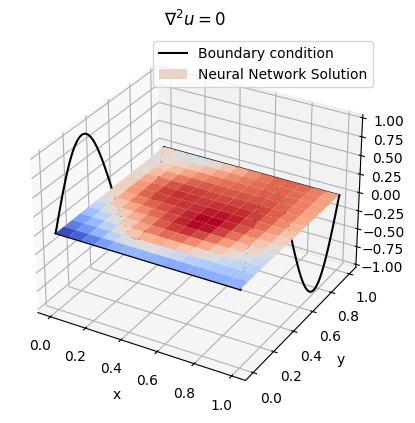

In [306]:
pred = model(xy_train).detach().numpy()
pred = np.reshape(pred,shape=(mesh_length,mesh_length))
np_x = x_train.detach().numpy()
np_y = y_train.detach().numpy()

zeros_b = np.zeros(100)
range_b = np.linspace(0, 1, 100)
u_b = np.sin(2 * np.pi * y_b)
ones_b = np.ones(100)

np_x, np_y = np.meshgrid(np_x, np_y)

fig, ax1 = plt.subplots(subplot_kw={"projection": "3d"})
ax1.plot(zeros_b, range_b, u_b, color='black', label= 'Boundary condition')
ax1.plot(range_b, zeros_b, zeros_b, color='black')
ax1.plot(ones_b, range_b, u_b, color='black')
ax1.plot(range_b, ones_b, zeros_b, color='black')
ax1.plot_surface(np_x, np_y, pred, label="Neural Network Solution", cmap = colmaps.coolwarm, antialiased=True)
ax1.legend()
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title(r'$\nabla^2{u} = 0$')

plt.show()

## Examples

Plot first and second derivatives, with mixed terms included

In [206]:
x = torch.tensor([2.0], requires_grad = True)
y = torch.tensor([3.0], requires_grad = True)
xs = torch.cartesian_prod(x,y)

def testf(xs):
    return xs[0,0]**4 * xs[0,1]**4

value = testf(xs)
#print(torch.autograd.grad(value, xs, create_graph=True, allow_unused=True))

# Calculate first-order derivatives with respect to the inputs
first_order_derivatives = torch.autograd.grad(value, xs, grad_outputs=torch.ones_like(value), create_graph=True)[0]

# My way of calculating
verify = []
verify.append(torch.autograd.grad(first_order_derivatives[:, 0], xs, grad_outputs=torch.ones_like(first_order_derivatives[:, 0]), create_graph=True)[0])
verify.append(torch.autograd.grad(first_order_derivatives[:, 1], xs, grad_outputs=torch.ones_like(first_order_derivatives[:, 1]), create_graph=True)[0])

# Calculate second-order derivatives (including mixed derivatives)
second_order_derivatives = torch.zeros((xs.size(1), xs.size(1)))
for i in range(xs.size(1)):
    grad2 = torch.autograd.grad(first_order_derivatives[:, i], xs, torch.ones_like(first_order_derivatives[:, i]), retain_graph=True)[0]
    second_order_derivatives[i, :]  = grad2

print(first_order_derivatives)
print(verify)
print(second_order_derivatives)


tensor([[2592., 1728.]], grad_fn=<AddBackward0>)
[tensor([[3888., 3456.]], grad_fn=<AddBackward0>), tensor([[3456., 1728.]], grad_fn=<AddBackward0>)]
tensor([[3888., 3456.],
        [3456., 1728.]])


In [175]:
first_order_derivatives[0, 0]

tensor(2592., grad_fn=<SelectBackward0>)

In [178]:
xs[0,1]

tensor(3., grad_fn=<SelectBackward0>)